# All Regression Notebook
## Load data
Declare and load the library, then load the dataset. Since the data do not contain the naming of columns, we had to add it in using a manual Python list

We will have `all_train_data` and `all_test_data`, which had been concatenated into their respective `DataFrame`.

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
columns_name = ["Popularity", "Check-in", "Activities", "Category"] \
            + ["F_{:d}".format(i) for i in range(1, 26)] \
            + ["CC{:d}".format(i) for i in range(1, 6)] \
            + ["Base time", "Post length", "Post count", "Post promotion", "Span time"] \
            + ["Post_date_{:d}".format(i) for i in range(1, 8)] \
            + ["Base_date_{:d}".format(i) for i in range(1, 8)] \
            + ["Span count"]
columns_name

['Popularity',
 'Check-in',
 'Activities',
 'Category',
 'F_1',
 'F_2',
 'F_3',
 'F_4',
 'F_5',
 'F_6',
 'F_7',
 'F_8',
 'F_9',
 'F_10',
 'F_11',
 'F_12',
 'F_13',
 'F_14',
 'F_15',
 'F_16',
 'F_17',
 'F_18',
 'F_19',
 'F_20',
 'F_21',
 'F_22',
 'F_23',
 'F_24',
 'F_25',
 'CC1',
 'CC2',
 'CC3',
 'CC4',
 'CC5',
 'Base time',
 'Post length',
 'Post count',
 'Post promotion',
 'Span time',
 'Post_date_1',
 'Post_date_2',
 'Post_date_3',
 'Post_date_4',
 'Post_date_5',
 'Post_date_6',
 'Post_date_7',
 'Base_date_1',
 'Base_date_2',
 'Base_date_3',
 'Base_date_4',
 'Base_date_5',
 'Base_date_6',
 'Base_date_7',
 'Span count']

In [3]:
import dask.dataframe as dd

In [5]:
train_data = dd.read_csv('Dataset/Training/*.csv',header=None)
train_data.columns = columns_name
train_data = train_data.compute()

In [7]:
test_data = dd.read_csv('Dataset/Testing/TestSet/*.csv',header=None)
test_data.columns = columns_name
test_data = test_data.compute()

In [8]:
train_data['bias'] = 1
test_data['bias'] = 1

In [9]:
train_data.head()

,Popularity,Check-in,Activities,Category,F_1,F_2,F_3,F_4,F_5,F_6,...,Post_date_7,Base_date_1,Base_date_2,Base_date_3,Base_date_4,Base_date_5,Base_date_6,Base_date_7,Span count,bias
0,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,0,1,0,1
1,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,1,0,0,1
2,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,0,1,0,1
3,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,1,0,0,0,0,0,0,1
4,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,1,0,0,0,0,1


## Selecting sub-category
The Category column contain arbitrary indices of the data category relating to the nature of the post itself. For the sake of simplification, we will just use the category with the largest amount of data to perform our Linear regression on.

Find and select the category with the most amount of records using pandas. Store it in the variable `largest_category`

In [10]:
train_data.Category.value_counts()

9     110313
24     66473
18     63314
36     35163
16     27805
       ...  
62       232
63        58
58        29
83        15
93        15
Name: Category, Length: 81, dtype: int64

In [11]:
largest_category = 9

In [12]:
# Categorize models
train_data = train_data.loc[train_data['Category'] == largest_category].drop('Category', axis=1)
test_data = test_data.loc[test_data['Category'] == largest_category].drop('Category', axis=1)

label = "Span count"
features = [col for col in train_data.columns if col != label]

train_features = train_data[ features ]
train_labels = train_data[ label ]
test_features = test_data[ features ]
test_labels = test_data[ label ]

## A basic correlation
As a little exercise, we will draw a correlation matrix between CC? variables. Correlation are useful to see if there are features that are too closely connected - and we don't want those together as they will introduce artificial noises that will overfit the model.

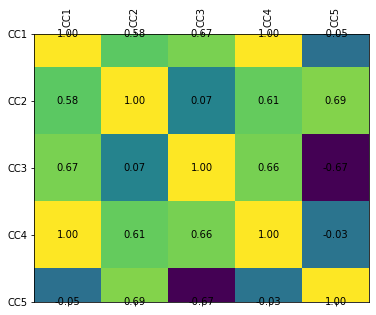

In [13]:
subdata = train_data[(col for col in train_data.columns if "CC" in col)]
correlation_matrix = subdata.corr()

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(correlation_matrix)

# this two lines may cause trouble with different versions of matplotlib. If it fail, try to delete and see.
plt.xticks(np.arange(len(correlation_matrix.columns)))
plt.yticks(np.arange(len(correlation_matrix.columns)))

ax.set_xticklabels(correlation_matrix.columns.values.tolist())
ax.set_yticklabels(correlation_matrix.columns.values.tolist())
plt.xticks(rotation=90)

for i, column in enumerate(correlation_matrix.values):
    for j, value in enumerate(column):
        text = ax.text(j, i, "%.2f" % value,
                       ha="center", va="center", color="black")
plt.show()

## Build Regression Models

__Our task is to predict the number of comments the post will receive ("Span count" column)__ <br>
"Span time" is necessary, while all other columns are optional <br>
Try a simple Multiple Regression model with only the basic features: <br>
["Popularity", "Base time", "Post length", "Post count", "Span time", "bias"] <br>

Print out either the MSE score from sklearn or the RSS score learned from the course for both training and testing dataset

In [14]:
basic_features = ["Popularity", "Base time", "Post length", "Post count", "Span time", "bias"]

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

basic_train_features = scaler.fit_transform(train_data[basic_features])
train_output = train_data[label]

basic_test_features = scaler.transform(test_data[basic_features])
test_output = test_data[label]

In [18]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(basic_train_features, train_output)

In [19]:
from sklearn.metrics import mean_squared_error
print("MSE of train :{:.2f} ".format(mean_squared_error(train_output, model.predict(basic_train_features))))

MSE of basic_train_features :1689.57 


In [20]:
print("MSE of test :{:.2f}".format(mean_squared_error(test_output, model.predict(basic_test_features))))

MSE of test :5477.09


### Try improving with more features
Not the greatest model we could use. We should try to add even more relevant features. <br>Append all the CC properties to the features and try again, with the same metrics.

In [23]:
more_features = basic_features + ["CC{:d}".format(i) for i in range(1,6)]

In [25]:
more_train_features = train_data[more_features]
more_test_features = test_data[more_features]

model = LinearRegression().fit(more_train_features, train_output)
print("MSE of train: {:.2f}".format(mean_squared_error(train_output, model.predict(more_train_features))))
print("MSE of test: {:.2f}".format(mean_squared_error(test_output, model.predict(more_test_features))))

MSE of train: 1535.02
MSE of test: 3999.83


Moral of the day: Premature optimization are rarely ever worth it.

## Resolve overfit
### Applying resolution for overfit

The discrepancy between the score of the training and testing indicate that we may be overfitting the model. Let's try to fix it. Span the Ridge regression with alpha along logspace between 0 and 10, record the value with the best performance as variable `best_alpha`, and *optionally draw a graph for the coefficients magnitude*.

In [26]:
from sklearn.linear_model import Ridge

In [45]:
test_MSE = []
min_MSE = None
weight = []
for l2_penalty in np.logspace(0, 10, num=21):
    model = Ridge(alpha=l2_penalty).fit(more_train_features, train_output)
    weight.append(model.coef_)
    MSE = mean_squared_error(test_output, model.predict(more_test_features))
    test_MSE.append(MSE)
    if min_MSE is None or min_MSE > MSE:
        min_MSE = MSE
        best_alpha = l2_penalty
test_MSE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.42216e-18): result may not be accurate.
  overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.49728e-18): result may not be accurate.
  overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.42216e-17): result may not be accurate.
  overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.49728e-17): result may not be accurate.
  overwrite_a=True).T


[3999.827143097441,
 3999.8272907976902,
 3999.82775786262,
 3999.829234808918,
 3999.833904896332,
 3999.8486687419054,
 3999.895313484123,
 4000.042391954231,
 4000.503281389721,
 4001.919780613264,
 4006.023920125091,
 4016.107694892367,
 4033.202565807952,
 4049.823749077407,
 4061.4525554330103,
 4077.4071989766276,
 4100.288191899557,
 4117.613728689835,
 4178.609602459862,
 4456.801434233608,
 4996.693398213989]

In [46]:
best_alpha

1.0

In [47]:
weight = pandas.DataFrame(weight)
weight

,0,1,2,3,4,5,6,7,8,9,10
0,9.919798e-07,-0.430641,0.000307,0.011274,0.234792,0.0,0.033801,0.082202,0.027166,-0.042422,0.055034
1,9.919798e-07,-0.430641,0.000307,0.011274,0.234791,0.0,0.033801,0.082201,0.027166,-0.042422,0.055035
2,9.919798e-07,-0.430641,0.000307,0.011274,0.234789,0.0,0.033801,0.082201,0.027166,-0.042422,0.055035
3,9.919798e-07,-0.430641,0.000307,0.011274,0.234782,0.0,0.033801,0.082201,0.027166,-0.042422,0.055035
4,9.919799e-07,-0.430640,0.000307,0.011274,0.234761,0.0,0.033800,0.082201,0.027166,-0.042421,0.055035
5,9.919800e-07,-0.430638,0.000307,0.011274,0.234695,0.0,0.033797,0.082201,0.027166,-0.042419,0.055035
6,9.919805e-07,-0.430631,0.000307,0.011274,0.234484,0.0,0.033789,0.082201,0.027166,-0.042410,0.055035
7,9.919821e-07,-0.430609,0.000307,0.011274,0.233822,0.0,0.033763,0.082202,0.027166,-0.042384,0.055036
8,9.919873e-07,-0.430537,0.000307,0.011275,0.231753,0.0,0.033682,0.082203,0.027166,-0.042301,0.055037
9,9.920048e-07,-0.430312,0.000306,0.011276,0.225444,0.0,0.033427,0.082208,0.027166,-0.042043,0.055043


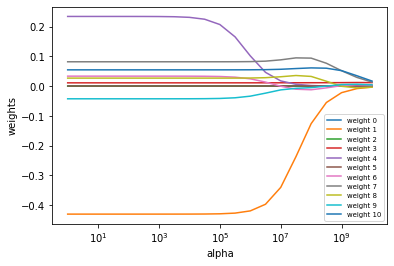

In [48]:
x = np.logspace(0, 10, num=21)
for i in range(len(more_features)):
    plt.plot(x, weight.iloc[:,i], label = "weight {:d}".format(i))
plt.xscale('log')
plt.xlabel('alpha')

plt.ylabel('weights')
plt.legend(loc="lower right",fontsize='x-small')
plt.show()

### Try Ridge Regression on every columns
It worked, but one have to wonder if we are still using the incomplete set of features instead of the optimal one. Expand the features to all columns except our designated label. Run and see what happens.

In [49]:
label = "Span count"
features = [col for col in train_data.columns if col != label]

train_features = train_data[ features ]
train_labels = train_data[ label ]
test_features = test_data[ features ]
test_labels = test_data[ label ]

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

multi_model = Ridge(alpha = best_alpha)
multi_model.fit(train_features, train_labels)
test_predictions = multi_model.predict(test_features)

test_mse_score = mean_squared_error(test_labels, test_predictions)
train_mse_score = mean_squared_error(train_labels, multi_model.predict(train_features))
print("MSE on training: {:.4f}; MSE on test: {:.4f}".format(train_mse_score, test_mse_score))

MSE on training: 1512.2733; MSE on test: 4121.6797


## Features selection
### Apply LASSO
Now, we can try trimming the features using something we had learned throughout the course. This time record the selected features of LASSO using variable `lasso_selected_features`, and <i>optionally draw a graph between number of removed features and alpha values</i>.

In [39]:
from sklearn.linear_model import Lasso

In [51]:
nonzero_list = []
test_MSE = []
min_MSE = None
for l1_penalty in np.logspace(0, 10, num=21):
    model = Lasso(alpha=l1_penalty).fit(train_features, train_labels)
    nonzero_list.append(np.count_nonzero(model.coef_))
    MSE = mean_squared_error(test_labels, model.predict(test_features))
    test_MSE.append(MSE)
    if min_MSE is None or min_MSE > MSE:
        min_MSE = MSE
        best_alpha = l1_penalty

In [52]:
best_alpha

3.1622776601683795

In [60]:
model = Lasso(alpha=best_alpha).fit(train_features, train_labels)
model.coef_

array([ 0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.66023749,  1.52160032,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        , 10.32258186,
       -0.        ,  0.        ,  2.24975848, -6.713375  ,  0.        ,
        4.88708683,  0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        ])

In [61]:
lasso_selected_features = np.array(features)[model.coef_ != 0].tolist()
lasso_selected_features

['F_8', 'F_9', 'CC2', 'CC5', 'Base time', 'Post count']

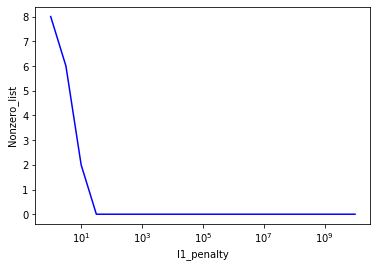

In [64]:
x = np.logspace(0, 10, num=21)
plt.plot(x, nonzero_list,"-b")
plt.xscale('log')
plt.xlabel("l1_penalty")
plt.ylabel("Nonzero_list")
plt.show()

### Build a model strictly with the selected features
Remember that when you do features selecting, you may have to re-add bias into the list of features yet again. Use the selected features to build a model and calculate the performance basing on the metrics.

In [65]:
if("bias" not in lasso_selected_features):
    lasso_selected_features.append('bias')

## Combine everything on one model
So LASSO performed admirably, shrinking aways unnecessary and noisy features and quicken the speed of calculation. Now let us combine both previous techniques together on one model.

In [71]:
label = "Span count"
features = lasso_selected_features

train_selected_features = train_data[features]
train_output = train_data[label]
test_selected_features = test_data[features]
test_output = test_data[label]

train_selected_features = scaler.fit_transform(train_selected_features)
test_selected_features = scaler.transform(test_selected_features)

model = Ridge(alpha = 1.0).fit(train_features, train_output)
print("MSE of train: {:.2f}".format(mean_squared_error(train_output, model.predict(train_selected_features))))
print("MSE of test: {:.2f}".format(mean_squared_error(test_output, model.predict(test_selected_features))))

MSE of train: 1520.34
MSE of test: 4696.14


### Distribution of square errors
The conclusion is yours to draw. As a side note, let's see how the square errors are distributed.

In [73]:
label = "Span count"
features = [col for col in train_data.columns if col != label]

train_features = train_data[ features ]
train_labels = train_data[ label ]
test_features = test_data[ features ]
test_labels = test_data[ label ]

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)


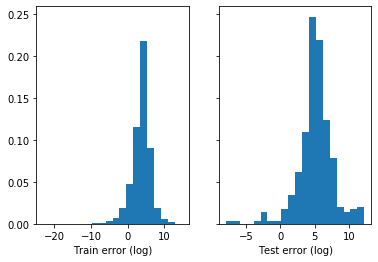

In [74]:
train_square_errors = np.log( (train_labels - multi_model.predict(train_features)) ** 2 )
test_square_errors = np.log( (test_labels - test_predictions) ** 2 )
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharey=True)
train_ax.hist(train_square_errors, bins=20, density=True)
train_ax.set_xlabel("Train error (log)")
test_ax.set_xlabel("Test error (log)")
test_ax.hist(test_square_errors, bins=20, density=True)
plt.show()